# Optuna

Optuna is an automatic hyperparameter tuning framework. Some of the basic functionality of Optuna will be demonstrated in this page.

In [57]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import warnings
warnings.filterwarnings('ignore')

X_train, y_train = make_classification(n_samples=1000, n_features=20, n_informative=15, shuffle=True, random_state=1)

```{admonition} Demonstration
:class: seealso
The following Kaggle notebook demonstrates the concepts explained in this page: [🎓 Optuna Demonstration](https://www.kaggle.com/drbeane/optuna-tutorial-titanic)
```

## Introduction to Optuna

**Importing Optuna**

Optuna is not included in the Anaconda distrubution. You can install Optuna with the conda package manager by running the following command in Anaconda Prompt:

    conda install -c conda-forge optuna


**Installing Optuna**

After installing Optuna, we can import the library into our Python session.

In [5]:
import optuna

To use Optuna to perform hyperparameter tuning for a specific model type, a study must be created. A study in **Optuna** refers to a single optimization problem. Each Optuna study consists of multiple trials. A **trial** in optuna is a single execution of a function that returns a value meanted to be minimized or maximized. In the context of hyperparameter tuning, a trail consists of selecting hyperparameter values for a model and then scoring the resulting model in some way, typically by using cross-validation. 

An outline of the steps involved in creating a study is as follows: 
1. Create an **objective function** representing a trail. 
    a. Within the objective function, new hyperparameter values should be selected. 
    b. A model object should be created using the new hyperparameter values.
    c. The model should be scored using cross-validation. 
    d. The cross-validation score should be returned by the objective function. 
2. Create a `study` object, indiciate if the objective should be minimized or maximized. 
3. Pass the objective function to the `study` object's `optimize()` method, specifying the number of trials to perform. This will start the study. 

The objective function should accept a single `trial` object as a parameter. Arguments for this parameter are supplied to the objective function when the `optimize()` function is called. 

The hyperparameter values are generated by using `suggest_float()`, `suggest_int()`, and `suggest_categorical()` methods of the `trial` object. The use of these methods will be demonstrated below. The paramaters passed to these methods will define the parameter **search space** for the study. Optuna makes use of [Bayesian optimization](https://en.wikipedia.org/wiki/Hyperparameter_optimization#Bayesian_optimization) to strategically explore the search space for an optimal set of parameter values. It does this by employing an explore/exploit strategy in which new values are selected at random for each new trial, but values that have previously shown good performance will be selected more frequently. 

## Tuning a Logistic Regression Model

The cell below demonstrates the use of Optuna in performing hyperparameter tuning for a logistic regression classifier. The specific hyperparameters being tuned will be `li_ratio` and `C`. Notice that values for these hyperparameters are generated using the `suggest_float()` method of the `trial` object. We pass 4 arguments to `suggest_float()` in each call. 

* The 1st argument is a string that provides a name for the hyperparameter being tuned. This can be set to anything you like and is used only for reporting purposes. 
* The 2nd argument provides the lower bound for values to be considered for the hyperparameter.
* The 3rd argument provides the upper bound for values to be considered for the hyperparameter.
* The 4th argument set the `log` parameter. If set to `False`, then values for the hyperparameter will be sampled according to a uniform distribution. If set to `True`, then values will be selected according to a uniform distribution on the log-space. The default value for `'log` is `False`. 

In [28]:
def logreg_objective(trial):
    
    r = trial.suggest_float('l1_ratio', 0, 1, log=False)
    c = trial.suggest_float('C', 1e-10, 1000, log=True)
     
    clf =  LogisticRegression(max_iter=5000, solver='saga', penalty='elasticnet', l1_ratio=r, C=c)
    scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='roc_auc')
    
    return scores.mean()
    
logreg_study = optuna.create_study(direction='maximize')
logreg_study.optimize(logreg_objective, n_trials=20)

[I 2021-11-20 12:02:29,595] A new study created in memory with name: no-name-5fd28f88-c24b-4f8e-8dcb-072a6a1cbc0b
[I 2021-11-20 12:02:29,616] Trial 0 finished with value: 0.5 and parameters: {'l1_ratio': 0.5439615394307834, 'C': 2.1771939082764177e-08}. Best is trial 0 with value: 0.5.
[I 2021-11-20 12:02:29,635] Trial 1 finished with value: 0.5 and parameters: {'l1_ratio': 0.488968701460022, 'C': 0.00017425521598500197}. Best is trial 0 with value: 0.5.
[I 2021-11-20 12:02:29,655] Trial 2 finished with value: 0.5 and parameters: {'l1_ratio': 0.19864784316264938, 'C': 6.789509511446001e-06}. Best is trial 0 with value: 0.5.
[I 2021-11-20 12:02:29,672] Trial 3 finished with value: 0.5 and parameters: {'l1_ratio': 0.3593833354400813, 'C': 1.678009740557353e-08}. Best is trial 0 with value: 0.5.
[I 2021-11-20 12:02:29,690] Trial 4 finished with value: 0.5 and parameters: {'l1_ratio': 0.5081372937816908, 'C': 2.430280354084403e-06}. Best is trial 0 with value: 0.5.
[I 2021-11-20 12:02:29,8

### Viewing Results

Each `study` object contains `best_value` and `best_params` attributes that record the score and hyperparameter values for the best trial found within the study. 

In [11]:
print(logreg_study.best_value)
print(logreg_study.best_params)

0.946138397839784
{'l1_ratio': 0.20439010954745684, 'C': 0.05549100030357322}


### Results DataFrame

A `study` object also has a `trails_dataframe()` method that returns a Pandas DataFrame with summary information about for all of the trials. This can be saved to a csv file to store the results of the study. It could be useful to identify and train multiple high-performing models from the study to use in an ensemble model. 

In [14]:
logreg_df = logreg_study.trials_dataframe()
logreg_df.head()

,number,value,datetime_start,datetime_complete,duration,params_C,params_l1_ratio,state
0,0,0.864617,2021-11-20 11:33:26.250878,2021-11-20 11:33:26.286782,0 days 00:00:00.035904,0.002365,0.434270,COMPLETE
1,1,0.946138,2021-11-20 11:33:26.287780,2021-11-20 11:33:26.324680,0 days 00:00:00.036900,0.055491,0.204390,COMPLETE
2,2,0.929858,2021-11-20 11:33:26.325677,2021-11-20 11:33:26.347619,0 days 00:00:00.021942,0.002320,0.088279,COMPLETE
3,3,0.945438,2021-11-20 11:33:26.348615,2021-11-20 11:33:26.488242,0 days 00:00:00.139627,1.485138,0.237773,COMPLETE
4,4,0.944938,2021-11-20 11:33:26.489240,2021-11-20 11:33:26.524147,0 days 00:00:00.034907,0.027652,0.638375,COMPLETE


## Tuning a Decision Tree Model

The cell below demonstrates the use of Optuna in performing hyperparameter tuning for a decision tree classifier. The specific hyperparameters being tuned will be `max_depth` and `min_samples_leaf`. These hyperparameter both expect integer values, which will be generated using the `suggest_int()` method of the `trial` object. The arguments passed to `suggest_int()` are similar to those for `suggest_float()`, but notice that we do not provide a value for the `log` parameter. This parameter is not used for `suggest_int()`. 

In [27]:
def dtree_objective(trial):
    
    md = trial.suggest_int('max_depth', 2, 64)
    mi = trial.suggest_int('min_inst', 1, 32)
    
    clf =  DecisionTreeClassifier(max_depth=md, min_samples_leaf=mi, random_state=1, )
    scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='roc_auc')
    
    return scores.mean()
    
dtree_study = optuna.create_study(direction='maximize')
dtree_study.optimize(dtree_objective, n_trials=20)

[I 2021-11-20 12:02:21,194] A new study created in memory with name: no-name-632bcc8d-e771-436f-9d8a-be022958be71
[I 2021-11-20 12:02:21,243] Trial 0 finished with value: 0.8688124402440245 and parameters: {'max_depth': 6, 'min_inst': 22}. Best is trial 0 with value: 0.8688124402440245.
[I 2021-11-20 12:02:21,300] Trial 1 finished with value: 0.8614617341734174 and parameters: {'max_depth': 39, 'min_inst': 8}. Best is trial 0 with value: 0.8688124402440245.
[I 2021-11-20 12:02:21,360] Trial 2 finished with value: 0.8246203520352035 and parameters: {'max_depth': 58, 'min_inst': 4}. Best is trial 0 with value: 0.8688124402440245.
[I 2021-11-20 12:02:21,405] Trial 3 finished with value: 0.8477817161716171 and parameters: {'max_depth': 18, 'min_inst': 30}. Best is trial 0 with value: 0.8688124402440245.
[I 2021-11-20 12:02:21,456] Trial 4 finished with value: 0.8710627762776276 and parameters: {'max_depth': 21, 'min_inst': 18}. Best is trial 4 with value: 0.8710627762776276.
[I 2021-11-20 

### Viewing Results

The cell below prints the `best_value` and `best_params` attributes for the decision tree study.

In [29]:
print(dtree_study.best_value)
print(dtree_study.best_params)

0.8778929582958297
{'max_depth': 30, 'min_inst': 15}


### Results DataFrame

In the cell below, the head of the results DataFrame is displayed for the decision tree study. 

In [30]:
dtree_df = dtree_study.trials_dataframe()
dtree_df.head()

,number,value,datetime_start,datetime_complete,duration,params_max_depth,params_min_inst,state
0,0,0.868812,2021-11-20 12:02:21.196195,2021-11-20 12:02:21.243069,0 days 00:00:00.046874,6,22,COMPLETE
1,1,0.861462,2021-11-20 12:02:21.244066,2021-11-20 12:02:21.300913,0 days 00:00:00.056847,39,8,COMPLETE
2,2,0.824620,2021-11-20 12:02:21.301911,2021-11-20 12:02:21.360754,0 days 00:00:00.058843,58,4,COMPLETE
3,3,0.847782,2021-11-20 12:02:21.361751,2021-11-20 12:02:21.405634,0 days 00:00:00.043883,18,30,COMPLETE
4,4,0.871063,2021-11-20 12:02:21.406631,2021-11-20 12:02:21.456498,0 days 00:00:00.049867,21,18,COMPLETE


## Study Visualizations

Optuna provides several functions for creating plots useful for visualizing information relating to a study. Two of these functions, `plot_optimization_history()` and `plot_slice()`, will be demonstrated in this page. Please refer to [Optuna Visualizations](https://optuna.readthedocs.io/en/stable/tutorial/10_key_features/005_visualization.html#sphx-glr-download-tutorial-10-key-features-005-visualization-py) for information on these and other available visualizations. 

The cell below imports the two visualization functions used in this page.


In [44]:
from optuna.visualization import plot_optimization_history, plot_slice

In [50]:
# Hack to get jupyterbook to display the plots
from optuna.visualization.matplotlib import plot_optimization_history, plot_slice

### Plot Optimization History

The `plot_optimization_history()` function displays scatter plot showing the results of each trial of a study in order. The plot also includes a line plot showing the best score that has been obtained as the study progresses. This plot is useful for helping you to determine if the study was still making progress when it completed the specified number of trials. 

<AxesSubplot:title={'center':'Optimization History Plot'}, xlabel='#Trials', ylabel='Objective Value'>

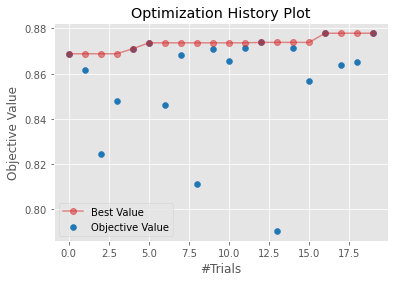

In [60]:
plot_optimization_history(dtree_study)

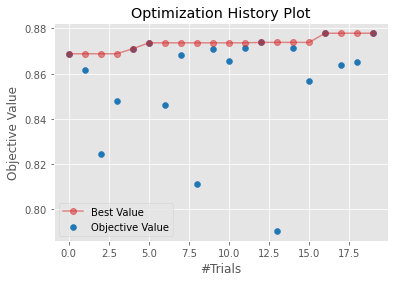

In [61]:
plot_optimization_history(dtree_study)
plt.show()

### Plot Slice

The `plot_slice()` function displays a grid of scatter plots with one plot for each parameter being tuned. Each plot will contain one dot for each trial, with the dot indicating the score for the trial and relevant parameter value used in that trial. These plots can be used to graphically illustrate which values were performing well for each parameter, and can help you to determine if the search space for your study should be expanded or adjusted. 

array([<AxesSubplot:xlabel='max_depth', ylabel='Objective Value'>,
       <AxesSubplot:xlabel='min_inst'>], dtype=object)

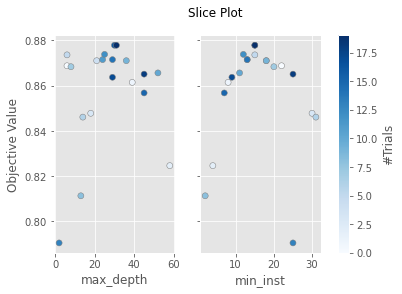

In [58]:
plot_slice(dtree_study)

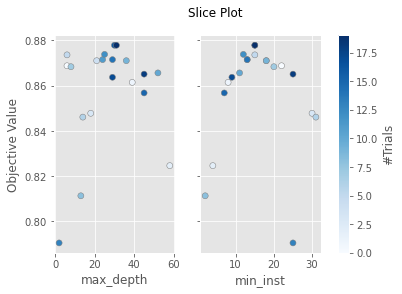

In [59]:
plot_slice(dtree_study)
plt.show()

## Additional Resources

The following resources contain additional information about Optuna. 

* [Optuna.org](https://optuna.org/)
* [Optuna Documentation](https://optuna.readthedocs.io/en/stable/)
* [Optuna Visualizations](https://optuna.readthedocs.io/en/stable/tutorial/10_key_features/005_visualization.html#sphx-glr-download-tutorial-10-key-features-005-visualization-py)
* [Optuna FAQ](https://optuna.readthedocs.io/en/latest/faq.html)